In [1]:
!pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import math
import random
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error
import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
# Downloading stock data for Chevron Corporation (CVX) from Yahoo Finance
stock_data = yf.download('CVX', start='2020-01-01', end='2024-01-01')
specific_df = pd.DataFrame(stock_data).reset_index()
specific_df['Name'] = 'CVX'
print(specific_df.head())

[*********************100%%**********************]  1 of 1 completed

        Date        Open        High         Low       Close   Adj Close  \
0 2020-01-02  120.809998  121.629997  120.769997  121.430000  101.413826   
1 2020-01-03  121.779999  122.720001  120.739998  121.010002  101.063065   
2 2020-01-06  121.239998  121.669998  120.330002  120.599998  100.720642   
3 2020-01-07  119.019997  119.730003  117.769997  119.059998   99.434479   
4 2020-01-08  118.550003  119.089996  117.650002  117.699997   98.298676   

    Volume Name  
0  5205000  CVX  
1  6360900  CVX  
2  9953000  CVX  
3  7856900  CVX  
4  7295900  CVX  


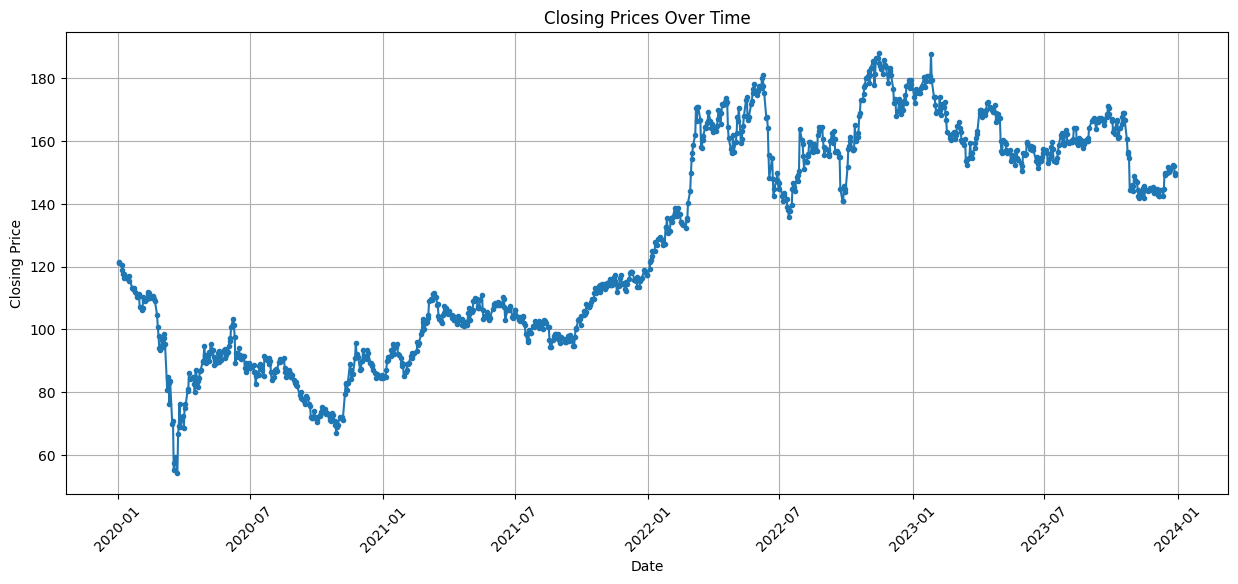

In [4]:
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

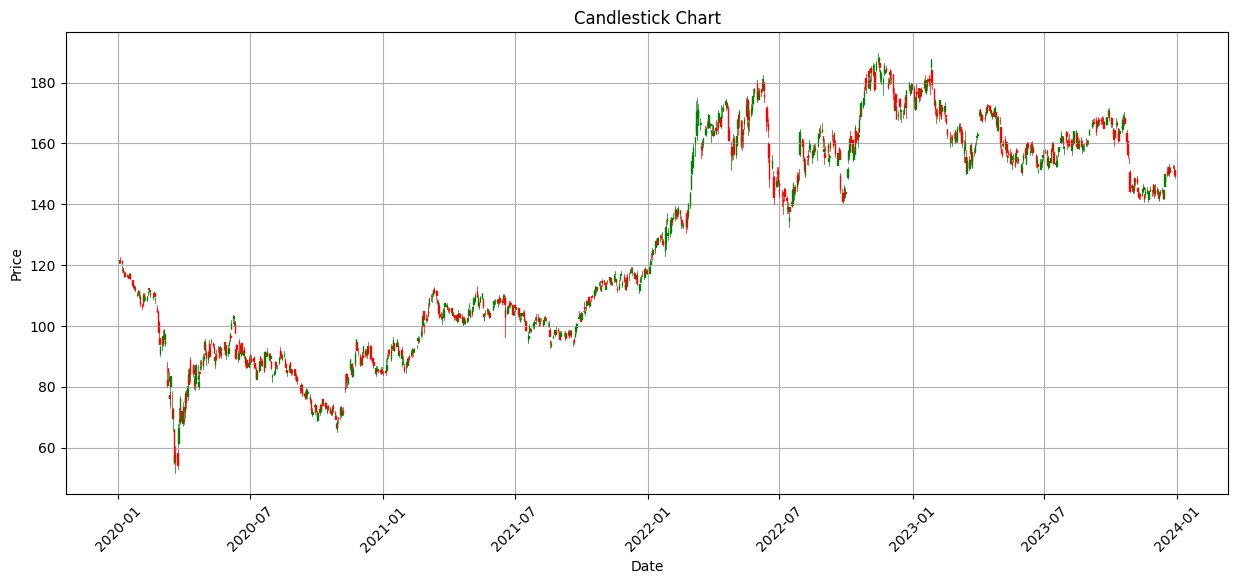

In [5]:
matplotlib_date = mdates.date2num(specific_df['Date'])
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T
plt.figure(figsize=(15,6))
ax=plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

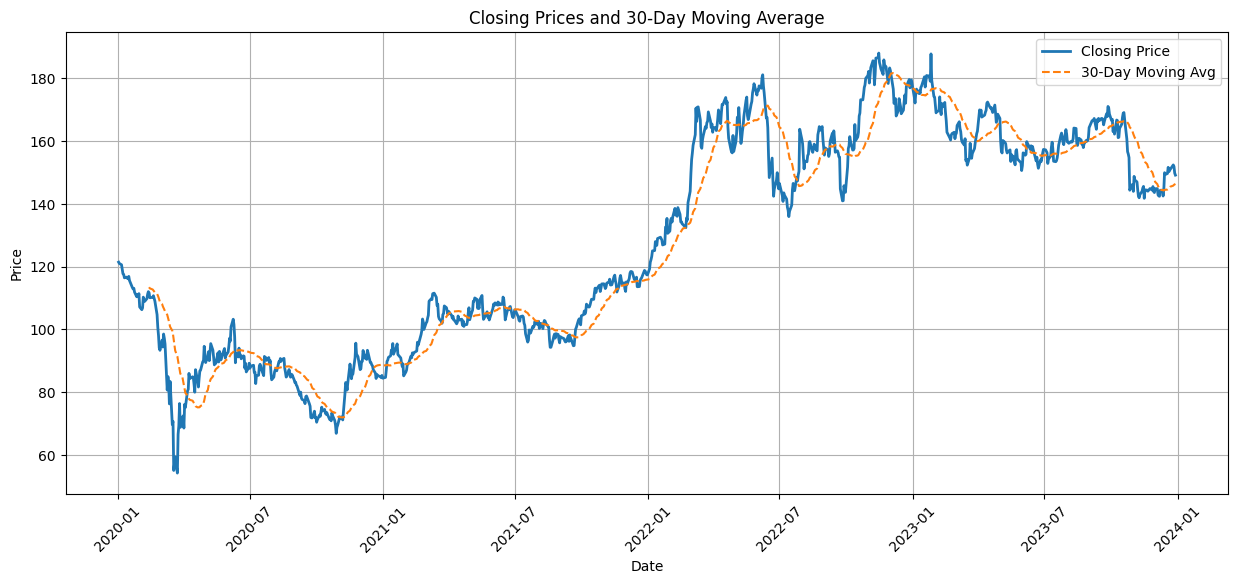

In [6]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

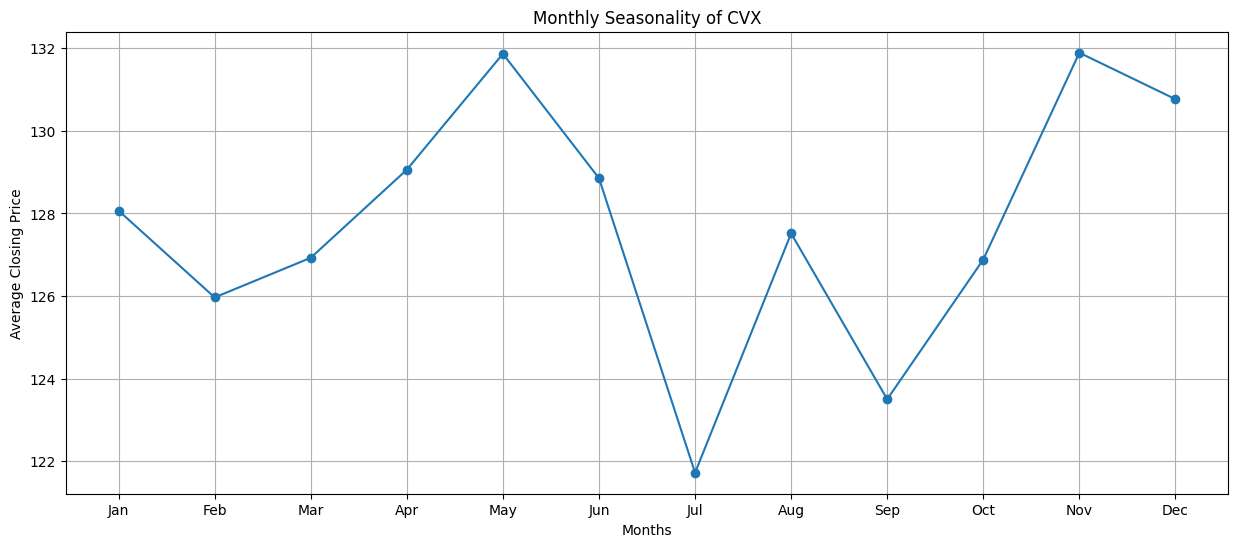

In [7]:
company_name = 'CVX'
specific_df['Month'] = specific_df['Date'].dt.month
monthly_average = specific_df.groupby('Month')['Close'].mean()

plt.figure(figsize=(15,6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [8]:
new_df = specific_df.reset_index()['Close']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [9]:
from sklearn.model_selection import train_test_split
test_size = 0.2
train_data, test_data = train_test_split(scaled_data, test_size=test_size, shuffle=False)

In [10]:
def generate_sequences_and_labels(data, n_past):
    sequences = [data[i - n_past:i, 0] for i in range(n_past, len(data))]
    labels = [data[i, 0] for i in range(n_past, len(data))]
    return np.array(sequences), np.array(labels)

In [11]:
n_past = 60
x_train, y_train = generate_sequences_and_labels(train_data, n_past)
x_test, y_test = generate_sequences_and_labels(test_data, n_past)

In [12]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [13]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=[input_shape, 1]))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [14]:
def compile_lstm_model(model):
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [15]:
def train_lstm_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=300, batch_size=32, verbose=1)

In [16]:
model = build_lstm_model(x_train.shape[1])
compile_lstm_model(model)
train_lstm_model(model, x_train, y_train, x_test, y_test)

Epoch 1/300
24/24 [==============================] - 9s 61ms/step - loss: 0.0614 - mean_absolute_error: 0.1744 - val_loss: 0.0026 - val_mean_absolute_error: 0.0363
Epoch 2/300
24/24 [==============================] - 0s 13ms/step - loss: 0.0107 - mean_absolute_error: 0.0777 - val_loss: 0.0017 - val_mean_absolute_error: 0.0319
Epoch 3/300
24/24 [==============================] - 0s 13ms/step - loss: 0.0069 - mean_absolute_error: 0.0626 - val_loss: 0.0032 - val_mean_absolute_error: 0.0418
Epoch 4/300
24/24 [==============================] - 0s 13ms/step - loss: 0.0080 - mean_absolute_error: 0.0676 - val_loss: 0.0020 - val_mean_absolute_error: 0.0372
Epoch 5/300
24/24 [==============================] - 0s 12ms/step - loss: 0.0056 - mean_absolute_error: 0.0554 - val_loss: 0.0016 - val_mean_absolute_error: 0.0303
Epoch 6/300
24/24 [==============================] - 0s 15ms/step - loss: 0.0056 - mean_absolute_error: 0.0550 - val_loss: 0.0026 - val_mean_absolute_error: 0.0445
Epoch 7/300
24/2

In [17]:
def make_predictions(model, x_train, x_test):
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    return train_predict, test_predict

In [18]:
train_predict, test_predict = make_predictions(model, x_train, x_test)

5/5 [==============================] - 0s 8ms/step


In [19]:
def inverse_transform(scaler, y_train, train_predict, y_test, test_predict):
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    return train_predict, test_predict

In [20]:
train_predict, test_predict = inverse_transform(scaler, y_train, train_predict, y_test, test_predict)

In [21]:
def evaluate_model(y_train, train_predict, y_test, test_predict):
    train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
    test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")

In [22]:
evaluate_model(y_train, train_predict, y_test, test_predict)

Training RMSE: 125.92351274834164
Testing RMSE: 156.51485411139993


In [23]:
def plot_predictions(original_data, train_predict, test_predict, company_name):
    look_back = 60
    train_predict_plot = np.empty_like(original_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[look_back : len(train_predict) + look_back] = train_predict.flatten()

    test_predict_plot = np.empty_like(original_data)
    test_predict_plot[:] = np.nan
    test_start = len(original_data) - len(test_predict)
    test_predict_plot[test_start:] = test_predict.flatten()

    plt.figure(figsize=(15, 6))
    plt.plot(original_data, color='black', label=f"Actual {company_name} price")
    plt.plot(train_predict_plot, color='red', label=f'Predicted {company_name} price (train_set)')
    plt.plot(test_predict_plot, color='blue', label=f"Predicted {company_name} price (test_set)")
    plt.title(f"{company_name} share price")
    plt.xlabel("Time")
    plt.ylabel(f"{company_name} share price")
    plt.legend()
    plt.show()


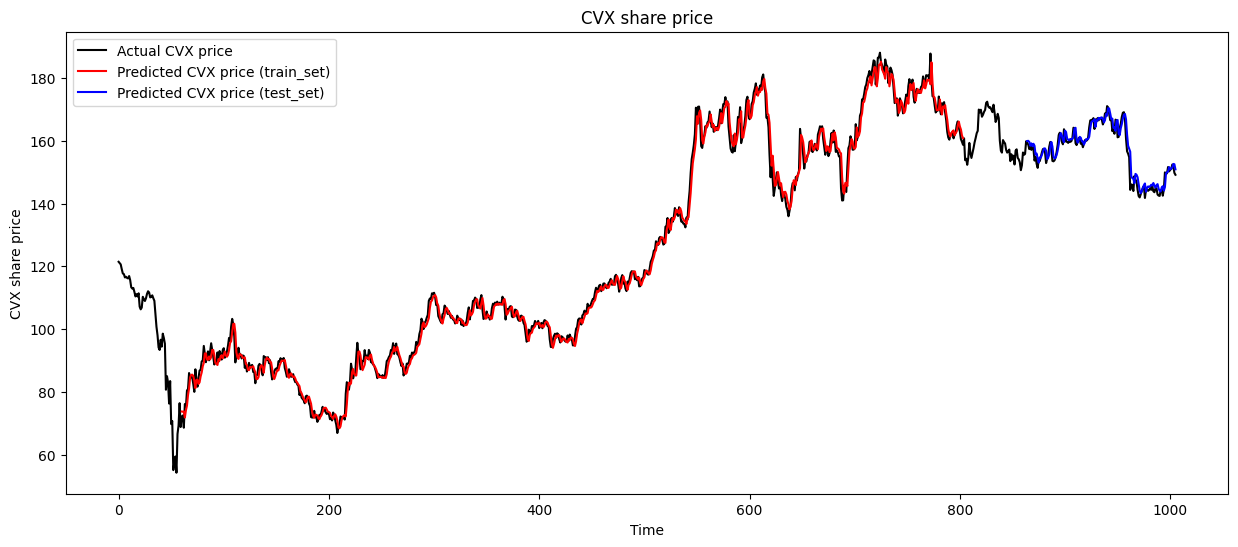

In [24]:
plot_predictions(new_df, train_predict, test_predict, company_name)

5/5 [==============================] - 0s 6ms/step
   Actual Close Prices  Predicted Close Prices
0           159.240005              159.908936
1           158.860001              159.977127
2           157.330002              159.631073
3           158.509995              158.415268
4           157.089996              159.165909


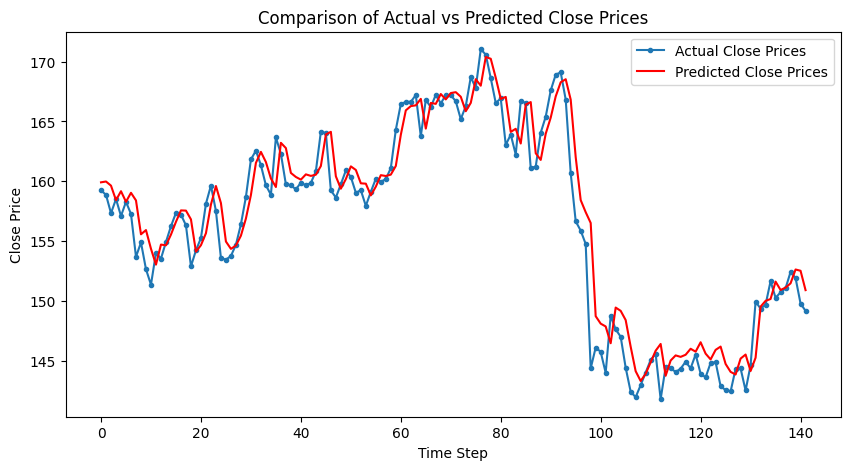

In [25]:
predictions = model.predict(x_test)

actual_values_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_values_inverse = scaler.inverse_transform(predictions)

comparison_df = pd.DataFrame({'Actual Close Prices': actual_values_inverse.flatten(), 'Predicted Close Prices': predicted_values_inverse.flatten()})
print(comparison_df.head())

plt.figure(figsize=(10, 5))
plt.plot(actual_values_inverse.flatten(), marker='.', label="Actual Close Prices")
plt.plot(predicted_values_inverse.flatten(), 'r', label="Predicted Close Prices")
plt.ylabel('Close Price')
plt.xlabel('Time Step')
plt.legend()
plt.title('Comparison of Actual vs Predicted Close Prices')
plt.show()
